In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
#from sklearn.model_selection import train_test_split
#from fbprophet import Prophet 
#from fbprophet.plot import add_changepoints_to_plot
#from fbprophet.diagnostics import cross_validation
import itertools
#from fbprophet.diagnostics import performance_metrics
import tensorflow
from tensorflow import keras
import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import pandas as pd 
import datetime
import numpy as np 
from matplotlib import style

In [2]:
warnings.filterwarnings('ignore')

In [3]:
#Lendo e transformando o arquivo CSV em um objeto pandas DataFrame nomeado de "df"
dff = pd.read_csv('C:/Users/juan_/Documents/GitHub/Datasets/demand.csv')

In [4]:
#Verificando o head e tail do CSV
dff

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500
...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016/4/27,1000
1048571,Product_1974,Whse_J,Category_006,2016/4/27,1
1048572,Product_1787,Whse_J,Category_006,2016/4/28,2500
1048573,Product_0901,Whse_J,Category_023,2016/10/7,50


In [5]:
#Analisando algumas informações a respeito do DataFrame
dff.describe()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
count,1048575,1048575,1048575,1037336,1048575
unique,2160,4,33,1729,3828
top,Product_1359,Whse_J,Category_019,2013/9/27,1000
freq,16936,764447,481099,2075,112682


In [6]:
#Verificando a existência de dados não preenchidos no DataFrame
dff.isnull().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

In [7]:
#Verificando a relação de dados faltantes com o total de dados
x = (11239/1048575)*100
print(f'Os dados faltantes equivalem à {round(x,3)}% do total dos dados do DataFrame')

Os dados faltantes equivalem à 1.072% do total dos dados do DataFrame


In [8]:
#Os dados não preenchidos beiram 1% do total dos dados, sendo assim, resolvi dropar os dados. 
#Outro motivo para dropar os dados é que não era possível estimar os dados faltantes.

#Dropando as linhas dos dados faltantes e atualizando o DF.
dff.dropna(inplace=True)
dff.isnull().sum()

Product_Code        0
Warehouse           0
Product_Category    0
Date                0
Order_Demand        0
dtype: int64

In [9]:
#Não está no notebook, mas alguns números possuíam parenteses, o código abaixo é para retirar esses parenteses (servirá lá na frente)
dff['Order_Demand']=dff['Order_Demand'].str.replace('(','',regex=True)
dff['Order_Demand']=dff['Order_Demand'].str.replace(')','',regex=True)

In [10]:
#O código abaixo separa os valores das datas, e após isso, cada valor é atribuído a uma nova coluna no DataFrame
dff[['Year','Month','Day']] = dff['Date'].str.split("/", expand = True)
dff[['Month']] = dff[['Month']].astype(int)
dff[['Year']] = dff[['Year']].astype(int)
#df[['Day']] = df[['Day']].astype(int)

#A retirada dos parenteses dos números foi necessário na hora de converter a coluna "Order_Demand" de str para int
dff[['Order_Demand']] = dff[['Order_Demand']].astype(int)

In [11]:
#Ordenando o DataFrame pela Data
dff['Test'] = dff['Year'].map(str) +'/'+ dff['Month'].map(str)
dff['Test'] = pd.to_datetime(dff['Test'])
dff.sort_values('Date', inplace=True)
dff.reset_index(inplace=True)
dff.drop('index',axis=1,inplace=True)
dff

,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Year,Month,Day,Test
0,Product_0965,Whse_A,Category_006,2011/1/8,2,2011,1,8,2011-01-01
1,Product_0412,Whse_S,Category_007,2011/10/20,2,2011,10,20,2011-10-01
2,Product_0125,Whse_S,Category_011,2011/10/20,2,2011,10,20,2011-10-01
3,Product_0642,Whse_C,Category_019,2011/10/31,3,2011,10,31,2011-10-01
4,Product_2137,Whse_S,Category_009,2011/11/18,25,2011,11,18,2011-11-01
...,...,...,...,...,...,...,...,...,...
1037331,Product_0689,Whse_J,Category_011,2017/1/6,200,2017,1,6,2017-01-01
1037332,Product_1970,Whse_J,Category_005,2017/1/6,2000,2017,1,6,2017-01-01
1037333,Product_1904,Whse_C,Category_019,2017/1/9,4000,2017,1,9,2017-01-01
1037334,Product_0471,Whse_C,Category_015,2017/1/9,30,2017,1,9,2017-01-01


In [12]:
#Verificando a quantidade de registros de cada armazens
dff[['Warehouse']].value_counts()

Warehouse
Whse_J       764447
Whse_A       142335
Whse_S        88200
Whse_C        42354
dtype: int64

In [13]:
#Analisando os dados do DataFrame original
xdf = dff['Order_Demand'].sum()
print(dff.nunique())
print(f'\nTotal of Order Demands: {xdf}')

Product_Code        2160
Warehouse              4
Product_Category      33
Date                1729
Order_Demand        3309
Year                   7
Month                 12
Day                   31
Test                  68
dtype: int64

Total of Order Demands: 5134173931


In [14]:
df_prod = dff[['Product_Code','Order_Demand','Date','Month','Year','Test']]
df_prod
df_prod[['Product_Code']].value_counts()

Product_Code
Product_1359    16936
Product_1295    10575
Product_1378     9770
Product_0620     9428
Product_1286     8888
                ...  
Product_1698        2
Product_1703        1
Product_0465        1
Product_2099        1
Product_0853        1
Length: 2160, dtype: int64

In [15]:
df = df_prod[(df_prod['Product_Code']=='Product_1295')]
#df['Test'] = df['Year'].map(str) +'/'+ df['Month'].map(str)
df

,Product_Code,Order_Demand,Date,Month,Year,Test
686,Product_1295,60000,2012/1/10,1,2012,2012-01-01
818,Product_1295,1000,2012/1/10,1,2012,2012-01-01
925,Product_1295,30000,2012/1/10,1,2012,2012-01-01
1014,Product_1295,1000,2012/1/10,1,2012,2012-01-01
1188,Product_1295,12000,2012/1/10,1,2012,2012-01-01
...,...,...,...,...,...,...
1036593,Product_1295,10000,2016/9/8,9,2016,2016-09-01
1036651,Product_1295,300,2016/9/9,9,2016,2016-09-01
1036842,Product_1295,30000,2016/9/9,9,2016,2016-09-01
1037058,Product_1295,10000,2016/9/9,9,2016,2016-09-01


In [16]:
#df['Date'] = pd.to_datetime(df['Date'])

In [17]:
df = df.groupby(by=['Test']).sum()
df.drop(columns=['Month','Year'],inplace=True)

In [18]:
df.reset_index(inplace=True)

In [19]:
#df['Date'] = pd.to_datetime(df['Test'])
#df

In [20]:
df['ds'] = df['Test']
df['y'] = df['Order_Demand']
df.drop(columns=['Test','Order_Demand'],inplace=True)

In [67]:
size = len(df) - 2 
size

58

In [68]:
train=df[:size]
test=df

In [69]:
train_data = train['y'].to_numpy()
print(train_data.shape)

test_data = test['y'].to_numpy()
print(test_data.shape)

(58,)
(60,)


In [70]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)

scaler.fit(train_data)
train_data = scaler.transform(train_data)

In [71]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [72]:
time_steps = 20
X_train, y_train = create_dataset(train_data, time_steps)

# reshape it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 20, 1))

print(X_train.shape)

(38, 20, 1)


In [73]:
y_train

array([0.1039303 , 0.6155582 , 0.58183414, 0.46856391, 0.61211057,
       0.54792202, 0.86115464, 0.4069454 , 0.2398295 , 0.43013853,
       0.55187112, 0.30871936, 1.        , 0.82385758, 0.74838588,
       0.51357112, 0.62596377, 0.41540776, 0.72212123, 0.63674544,
       0.34338369, 0.56716605, 0.97009967, 0.34971479, 0.40337241,
       0.47802921, 0.43352348, 0.49445245, 0.37159155, 0.33548549,
       0.82799473, 0.75847803, 0.26979252, 0.64288848, 0.36732903,
       0.45602708, 0.4942644 , 0.57744625])

In [74]:
print('X_train:')
print(str(scaler.inverse_transform(X_train[0])))
print("\n")
print('y_train: ' + str(scaler.inverse_transform(y_train[0].reshape(-1,1)))+'\n')

X_train:
[[1360800.]
 [1863200.]
 [2190800.]
 [1817400.]
 [1330700.]
 [1676100.]
 [1368000.]
 [1396600.]
 [1420500.]
 [1900300.]
 [1828900.]
 [1757300.]
 [1630300.]
 [2064200.]
 [2511300.]
 [1601900.]
 [1832500.]
 [1912600.]
 [2082200.]
 [1651600.]]


y_train: [[1496500.]]



In [93]:
model = keras.Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

#earlystop
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10)

# Fitting the model to the Training set
history = model.fit(X_train, y_train, epochs = 20, batch_size = 10, validation_split=.30, shuffle=False, callbacks=[es_callback])

Epoch 1/20
3/3 [==============================] - 5s 552ms/step - loss: 0.2444 - val_loss: 0.0474
Epoch 2/20
3/3 [==============================] - 0s 43ms/step - loss: 0.0929 - val_loss: 0.0895
Epoch 3/20
3/3 [==============================] - 0s 46ms/step - loss: 0.0675 - val_loss: 0.0448
Epoch 4/20
3/3 [==============================] - 0s 39ms/step - loss: 0.0491 - val_loss: 0.0287
Epoch 5/20
3/3 [==============================] - 0s 48ms/step - loss: 0.0603 - val_loss: 0.0304
Epoch 6/20
3/3 [==============================] - 0s 41ms/step - loss: 0.0571 - val_loss: 0.0287
Epoch 7/20
3/3 [==============================] - 0s 46ms/step - loss: 0.0550 - val_loss: 0.0344
Epoch 8/20
3/3 [==============================] - 0s 37ms/step - loss: 0.0494 - val_loss: 0.0469
Epoch 9/20
3/3 [==============================] - 0s 39ms/step - loss: 0.0513 - val_loss: 0.0447
Epoch 10/20
3/3 [==============================] - 0s 39ms/step - loss: 0.0505 - val_loss: 0.0335
Epoch 11/20
3/3 [===========

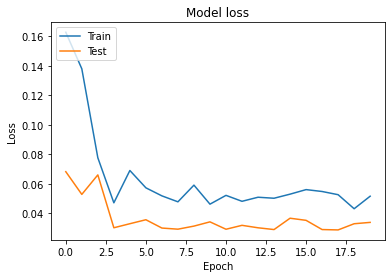

In [87]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [88]:
test

,ds,y
0,2012-01-01,1360800
1,2012-02-01,1863200
2,2012-03-01,2190800
3,2012-04-01,1817400
4,2012-05-01,1330700
5,2012-06-01,1676100
6,2012-07-01,1368000
7,2012-08-01,1396600
8,2012-09-01,1420500
9,2012-10-01,1900300


In [89]:
test_data = test['y'].values
test_data = test_data.reshape(-1,1)
test_data = scaler.transform(test_data)

# Create the data to test our model on:
time_steps = 1
X_test, y_test = create_dataset(test_data, time_steps)

# store the original vals for plotting the predictions 
y_test = y_test.reshape(-1,1)
org_y = scaler.inverse_transform(y_test)

# reshape it [samples, time steps, features]
#X_test = np.reshape(X_test, (X_test.shape[0], 20, 1))

# Predict the prices with the model
predicted_y = model.predict(X_test)
predicted_y = scaler.inverse_transform(predicted_y)

In [92]:
predicted_y

array([[1415015.4],
       [1441887.2],
       [1459255.6],
       [1439449.4],
       [1413396.5],
       [1431913. ],
       [1415402.5],
       [1416939.5],
       [1418223.4],
       [1443860.4],
       [1440061.8],
       [1436246.6],
       [1429465.4],
       [1452558.2],
       [1476127.6],
       [1427946.5],
       [1440253.4],
       [1444514.2],
       [1453511.6],
       [1430604. ],
       [1422301.5],
       [1465686.8],
       [1462850.5],
       [1453299.8],
       [1465397.1],
       [1459995.1],
       [1486240.2],
       [1448088.4],
       [1433899.2],
       [1450051.2],
       [1460327.8],
       [1439758.2],
       [1497780.1],
       [1483130.6],
       [1476825.2],
       [1457099.2],
       [1466561.4],
       [1448804.9],
       [1474626.9],
       [1467467. ],
       [1442701.1],
       [1461615.9],
       [1495299.9],
       [1443238.2],
       [1447786. ],
       [1454099.4],
       [1450337.6],
       [1455486. ],
       [1445093.5],
       [1442031. ],


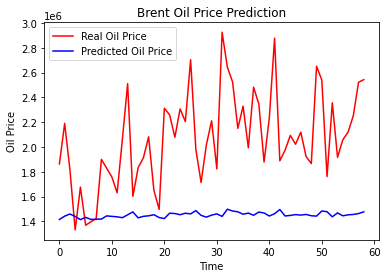

In [90]:
plt.plot(org_y, color = 'red', label = 'Real Oil Price')
plt.plot(predicted_y, color = 'blue', label = 'Predicted Oil Price')
plt.title('Brent Oil Price Prediction')
plt.xlabel('Time')
plt.ylabel('Oil Price')
plt.legend()
plt.show()